# Chronic Absenteeism Rate Prediction (CARP) Model Evaluation (ME)

### Make preparations specific to IBM Watson Studio:  import and configure project utilities, define function to download project assets

In [9]:
# The code was removed by Watson Studio for sharing.

In [10]:
# function to retrieve project assets 
def download(project_file_name,project=None):    
    # get the file
    print("Attempting to get file {}".format(project_file_name))
    _bytes = project.get_file(project_file_name).read()
    
    # download the file
    print("Downloading...")
    
    with open(project_file_name, 'wb') as f: 
        f.write(bytearray(_bytes))
        print("Completed writing out file")
        
    return 0

### Import required modules

In [11]:
import numpy as np
import pandas as pd

import re

import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

### Download, standardize, and verify model results datasets created by CARP-NN (Neural Network) and CARP-DTE (Decision Tree Ensemble)

In [12]:
nn_results_file_name = 'nn_results.p'
download(nn_results_file_name,project)
nn_results = pickle.load(open(nn_results_file_name,'rb'))

dte_results_file_name = 'dte_results.p'
download(dte_results_file_name,project)
dte_results = pickle.load(open(dte_results_file_name,'rb'))
print('\nNeural Network Results:\t\t', nn_results.keys(),'\nDecision Tree Ensemble Results:\t', dte_results.keys())

### Standardize and verify Consistency of data, especially since neural network data has been scaled and then inverse scaled in CARP-DNN data

iterations = len(dte_results['test_scores'])
# Should print "True" (2 * iterations) times
for i in range(iterations):
    dte_results['X_tests'][i] = dte_results['X_tests'][i].values[:,:25]
    dte_results['y_tests'][i] = dte_results['y_tests'][i].values.reshape(-1,1)
    nn_results['y_tests'][i] = nn_results['y_tests'][i].reshape(-1,1)
    print(np.allclose(dte_results['X_tests'][i],nn_results['X_tests'][i]))
    print(np.allclose(dte_results['y_tests'][i],nn_results['y_tests'][i]))

Attempting to get file nn_results.p
Downloading...
Completed writing out file
Attempting to get file dte_results.p
Downloading...
Completed writing out file

Neural Network Results:		 dict_keys(['X_mean', 'X_std', 'X_tests', 'y_tests', 'y_test_preds', 'train_scores', 'test_scores']) 
Decision Tree Ensemble Results:	 dict_keys(['X_mean', 'X_std', 'X_tests', 'y_tests', 'y_test_preds', 'train_scores', 'test_scores'])
True
True
True
True
True
True
True
True
True
True


### Compare coefficient of determination for each iteration

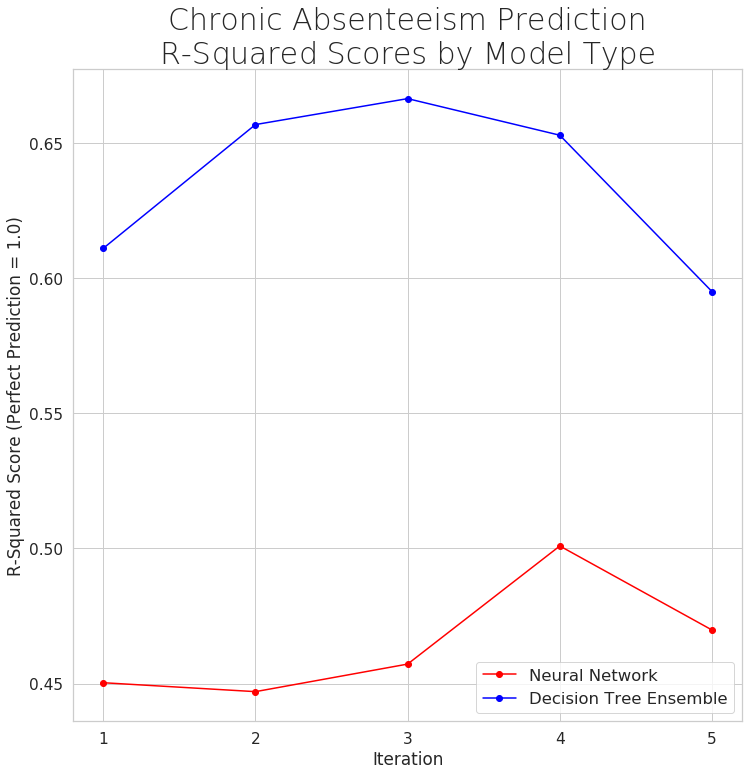

In [13]:
nn_r2_scores = nn_results['test_scores']
dte_r2_scores = dte_results['test_scores']

fig, ax = plt.subplots(figsize=(12,12))
sns.set(style="whitegrid", color_codes=True, font_scale=1.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

iterations = list(range(1,6))
# data
df=pd.DataFrame({'x': iterations, 'nn_r2': nn_r2_scores, 'dte_r2': dte_r2_scores })
# plot
plt.plot( 'x','nn_r2', data=df, color = 'red', label='Neural Network', linestyle='-', marker='o')
plt.plot( 'x','dte_r2', data=df, color = 'blue', label='Decision Tree Ensemble', linestyle='-', marker='o')

plt.ylabel('R-Squared Score (Perfect Prediction = 1.0)')
plt.xlabel('Iteration')

ax.set_title('Chronic Absenteeism Prediction\nR-Squared Scores by Model Type',
              fontdict={'fontsize': '30',
                        'fontweight' : '99'})
plt.legend()
plt.show()

plt.show()

### Select results with median test scores from better-performing prediction to avoid outlying performances

In [14]:
#TODO Add logic for even number of iterations:  One solution would be to append negative infinity as a test score to make the median equal to an array entry. 
#     This entry would be less than the actual median, and therefore a conservative selection.    

dte_median = np.median(dte_results['test_scores'])

dte_median_tuple = np.where(dte_results['test_scores'] == dte_median)

median_index = dte_median_tuple[0][0]

dte_y_test = dte_results['y_tests'][median_index]
dte_y_test_pred = dte_results['y_test_preds'][median_index].reshape(-1,1)

nn_y_test = nn_results['y_tests'][median_index]
nn_y_test_pred = nn_results['y_test_preds'][median_index].reshape(-1,1)


### Compute and visualize residuals

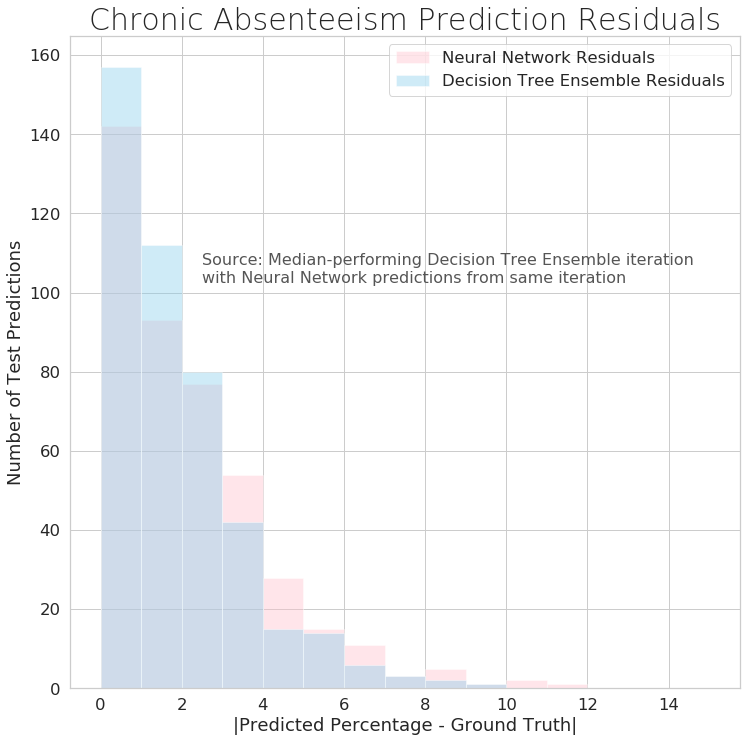

In [15]:
nn_residuals=abs(nn_y_test - nn_y_test_pred)
dte_residuals=abs(dte_y_test - dte_y_test_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.set(style="ticks", color_codes=True, font_scale=1.5)
bins = range(0, 16)
sns.distplot(nn_residuals[:,0], ax=ax,kde=False, color="pink", bins=bins, label="Neural Network Residuals")
sns.distplot(dte_residuals[:,0], ax=ax, kde = False, color="skyblue", bins=bins, label="Decision Tree Ensemble Residuals")


ax.set_title('Chronic Absenteeism Prediction Residuals',
              fontdict={'fontsize': '30',
                        'fontweight' : '99'})

_ = ax.annotate('Source: Median-performing Decision Tree Ensemble iteration\nwith Neural Network predictions from same iteration',
           xy=(2.5, 110),
           horizontalalignment='left', verticalalignment='top',
           fontsize=16, color='#555555')
_ = plt.xlabel('|Predicted Percentage - Ground Truth|')
_ = plt.ylabel('Number of Test Predictions')
_ = ax.legend()

### Visualize and compare prediction accuracy using a scatter plot with identity and +/- 5% lines 

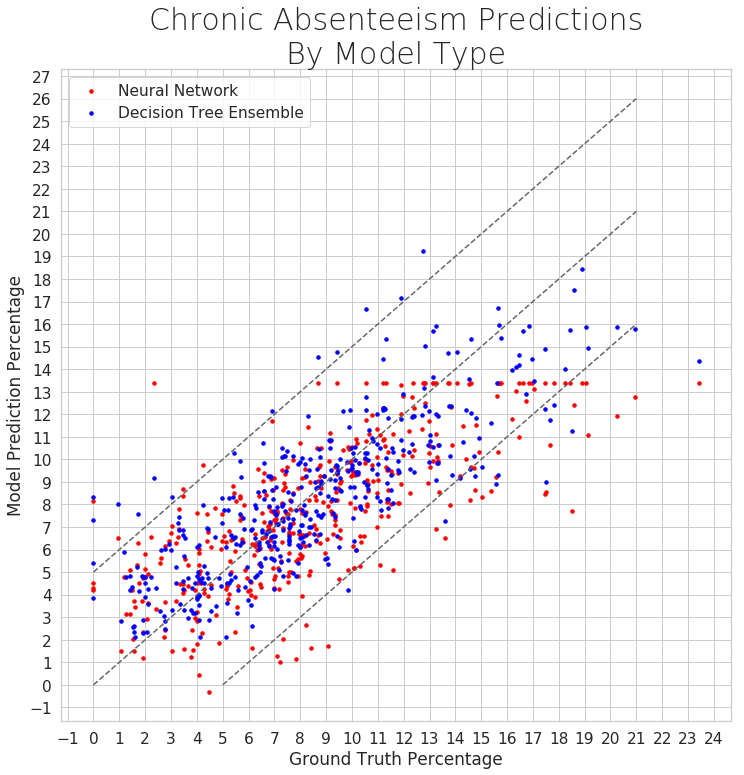

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
sns.set(style="whitegrid", color_codes=True, font_scale=1.4)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# data
#d = {'x': dte_y_test, 'nn_pred': nn_y_test_pred, 'dte_pred': dte_y_test_pred }

predictions = pd.DataFrame({'x': dte_y_test[:,0], 'nn_pred': nn_y_test_pred[:,0], 'dte_pred': dte_y_test_pred[:,0] }, index=range(len(dte_y_test))).astype(float)
# plot
plt.scatter( 'x','nn_pred', data=predictions, color = 'red', label='Neural Network',s=12)
plt.scatter( 'x','dte_pred', data=predictions, color = 'blue', label='Decision Tree Ensemble', s=12)

plt.plot([0,21],[0,21], ls='--', c='.4')
plt.plot([0,21],[5,26], ls='--', c='.4')
plt.plot([5,21],[0,16], ls='--', c='.4')

plt.ylabel('Model Prediction Percentage')
plt.xlabel('Ground Truth Percentage')

ax.set_title('Chronic Absenteeism Predictions\nBy Model Type',
              fontdict={'fontsize': '30',
                        'fontweight' : '99'})
plt.legend()
plt.show()

plt.show()